In [1]:
import sys
dirname = '/Users/muhammaddaffarobani/Documents/personal_research/smt'
if dirname not in sys.path:
    sys.path.append(dirname)
    
from smt.utils.design_space import (
    DesignSpace,
    FloatVariable,
    CategoricalVariable,
)
from smt.applications.mixed_integer import (
    MixedIntegerKrigingModel,
)
from smt.surrogate_models import (
    KPLS,
    MixIntKernelType,
    MixHrcKernelType,
)
from sklearn.metrics import mean_squared_error
from smt.explainability_tools import ShapFeatureImportanceDisplay, ShapDisplay

import time
import numpy as np


# Creating the model

In [2]:
# Objective function
def cantilever_deflection(x):
    norm_inertia_vals = [
        0.0833, 0.139, 0.380, 0.0796,
        0.133, 0.363, 0.0859, 0.136,
        0.360, 0.0922, 0.138, 0.369,
    ]
    
    I = int(x[0])
    L = x[1]
    S = x[2]
    norm_inertia = norm_inertia_vals[I]

    E = 200e9
    P = 50e3

    y = (P * L**3) / (3 * E * S**2 * norm_inertia)

    return y

In [3]:
%%time
"""Problem definition"""
# Design space
ds = DesignSpace([
    CategoricalVariable([
        "type_A", "type_B", "type_C", "type_D", 
        "type_E", "type_F", "type_G", "type_H", 
        "type_I", "type_J", "type_K", "type_L",
    ]),
    FloatVariable(10.0, 20.0),
    FloatVariable(1.0, 2.0),
])
categorical_feature_idx = [0]

f_obj = cantilever_deflection

# Create training and testing data
n_data = 150
n_train = int(0.8 * n_data)
n_test = n_data - n_train
xdoe, _ = ds.sample_valid_x(n_data)
y_doe = [f_obj(xdoe[i]) for i in range(len(xdoe))]

X_tr, y_tr = xdoe[:n_train, :], y_doe[:n_train]
X_te, y_te = xdoe[n_train:, :], y_doe[n_train:]
y_tr, y_te = np.array(y_tr), np.array(y_te)

# Name of the features
feature_names = [r'$I$', r'$L$', r'$S$']

# create mapping for the categories
categories_map = dict()
inverse_categories_map = dict()
for feature_idx in categorical_feature_idx:
    categories_map[feature_idx] = {
        i: value for i, value in enumerate(ds._design_variables[feature_idx].values)
    }
    inverse_categories_map[feature_idx] = {
        value: i for value, i in enumerate(ds._design_variables[feature_idx].values)
    }

"""Modelling"""
sm = MixedIntegerKrigingModel(
    surrogate=KPLS(
        design_space=ds,
        categorical_kernel=MixIntKernelType.HOMO_HSPHERE,
        hierarchical_kernel=MixHrcKernelType.ARC_KERNEL,
        theta0=np.array([4.43799547e-04, 4.39993134e-01, 1.59631650e+00]),
        corr="squar_exp",
        n_start=1,
        cat_kernel_comps=[2],
        n_comp=2,
        print_global=False,
        ),
    )
start_time = time.time()
sm.set_training_values(X_tr, np.array(y_tr))
sm.train()
print("run time (s):", time.time() - start_time)
y_pred = sm.predict_values(X_te)
rmse = mean_squared_error(y_te, y_pred, squared=False)
rrmse = rmse / y_te.mean()
print(f"RMSE: {rmse:.4f}")
print(f"rRMSE: {rrmse:.4f}")

run time (s): 18.183140993118286
RMSE: 0.0001
rRMSE: 0.0946
CPU times: user 59.5 s, sys: 1min 8s, total: 2min 8s
Wall time: 20.8 s


In [25]:
import pandas as pd
pd.Series(X_tr[:, 0]).value_counts()

4.0     12
1.0     12
11.0    12
7.0     11
0.0     11
3.0     11
9.0     10
2.0     10
5.0      9
10.0     9
8.0      8
6.0      5
Name: count, dtype: int64

# Feature Importance

Using `ShapFeatureImportanceDisplay.from_surrogate_model` method
- Required parameters:
    - model: surrogate model. 
    - X: input spaces as a reference to create the partial dependence plot. 

- Config parameters:
    - cat_feature_indexes: list of categorical features index. this is crucial for the computation.
    - feature_names: name of the features for the axis. 
    - sort: if True, sort the features based on the feature importance. 

CPU times: user 7.99 s, sys: 8.37 s, total: 16.4 s
Wall time: 2.29 s


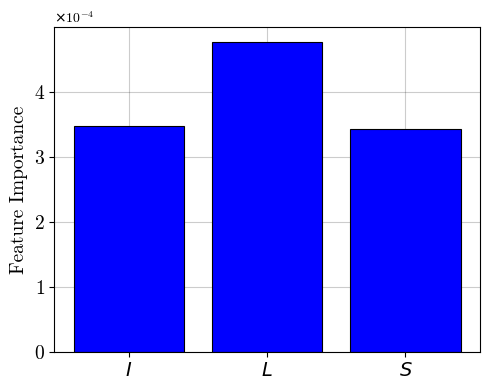

In [5]:
%%time
model = sm
X = X_tr

feature_importance = ShapFeatureImportanceDisplay.from_surrogate_model(
    model, 
    X, 
    feature_names=feature_names,
    cat_feature_indexes=categorical_feature_idx,
)

# SHAP Explainer

## Individual plot

sdsd

CPU times: user 1.93 s, sys: 3.32 s, total: 5.25 s
Wall time: 749 ms


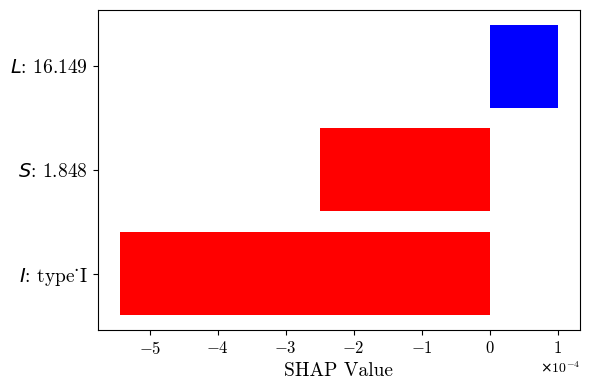

In [8]:
%%time
instances = X_te
model = sm
X = X_tr
# filename = "example_results/shap/blabla.png"

explainer_test = ShapDisplay.from_surrogate_model(
    instances, 
    model, 
    X, 
    feature_names=feature_names,
    cat_feature_indexes=categorical_feature_idx, 
    categories_map=categories_map,
)
# display.individual_plot(filename=filename)
explainer_test.individual_plot(index=0)

## Dependence plot

In [9]:
%%time
instances = X_tr
model = sm
X = X_tr

explainer_train = ShapDisplay.from_surrogate_model(
    instances, 
    model, 
    X_tr, 
    feature_names=feature_names,
    cat_feature_indexes=categorical_feature_idx,
    categories_map=categories_map,
)

CPU times: user 10.4 s, sys: 7.28 s, total: 17.6 s
Wall time: 2.6 s


CPU times: user 668 ms, sys: 18.1 ms, total: 686 ms
Wall time: 296 ms


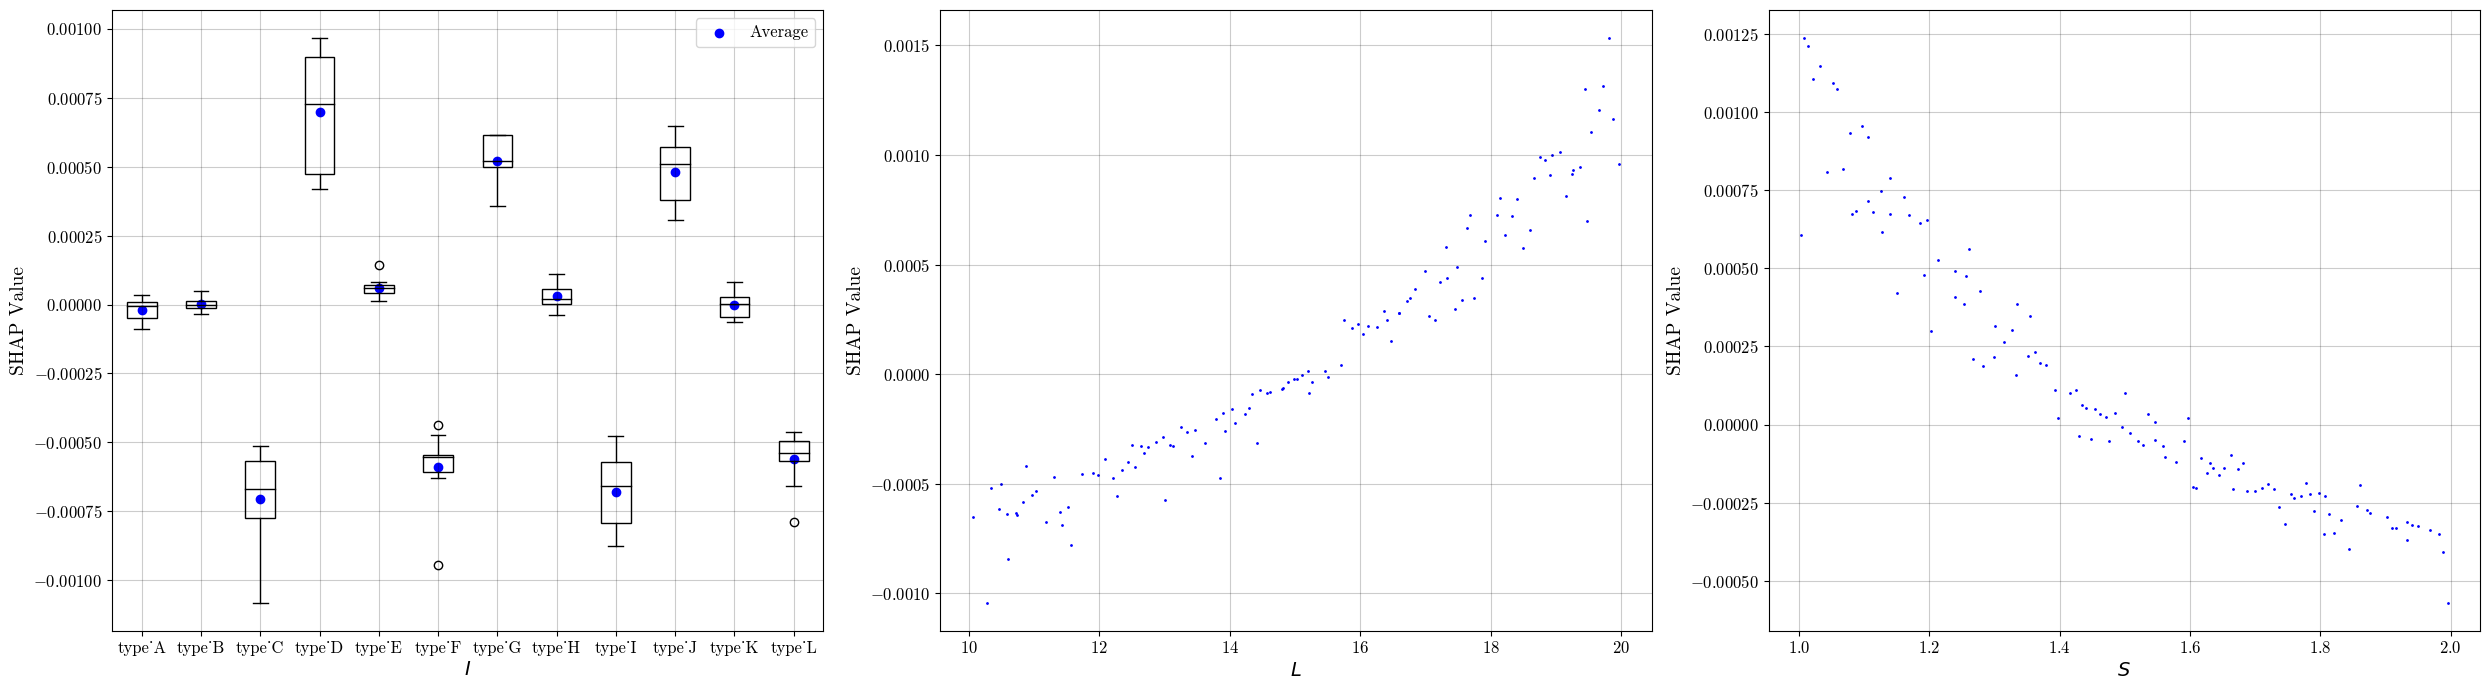

In [10]:
%%time
features = [0, 1, 2]

explainer_train.dependence_plot(
    features, 
    sort_based_on_importance=False,
    figsize=[25, 7],
)

CPU times: user 844 ms, sys: 44.2 ms, total: 888 ms
Wall time: 344 ms


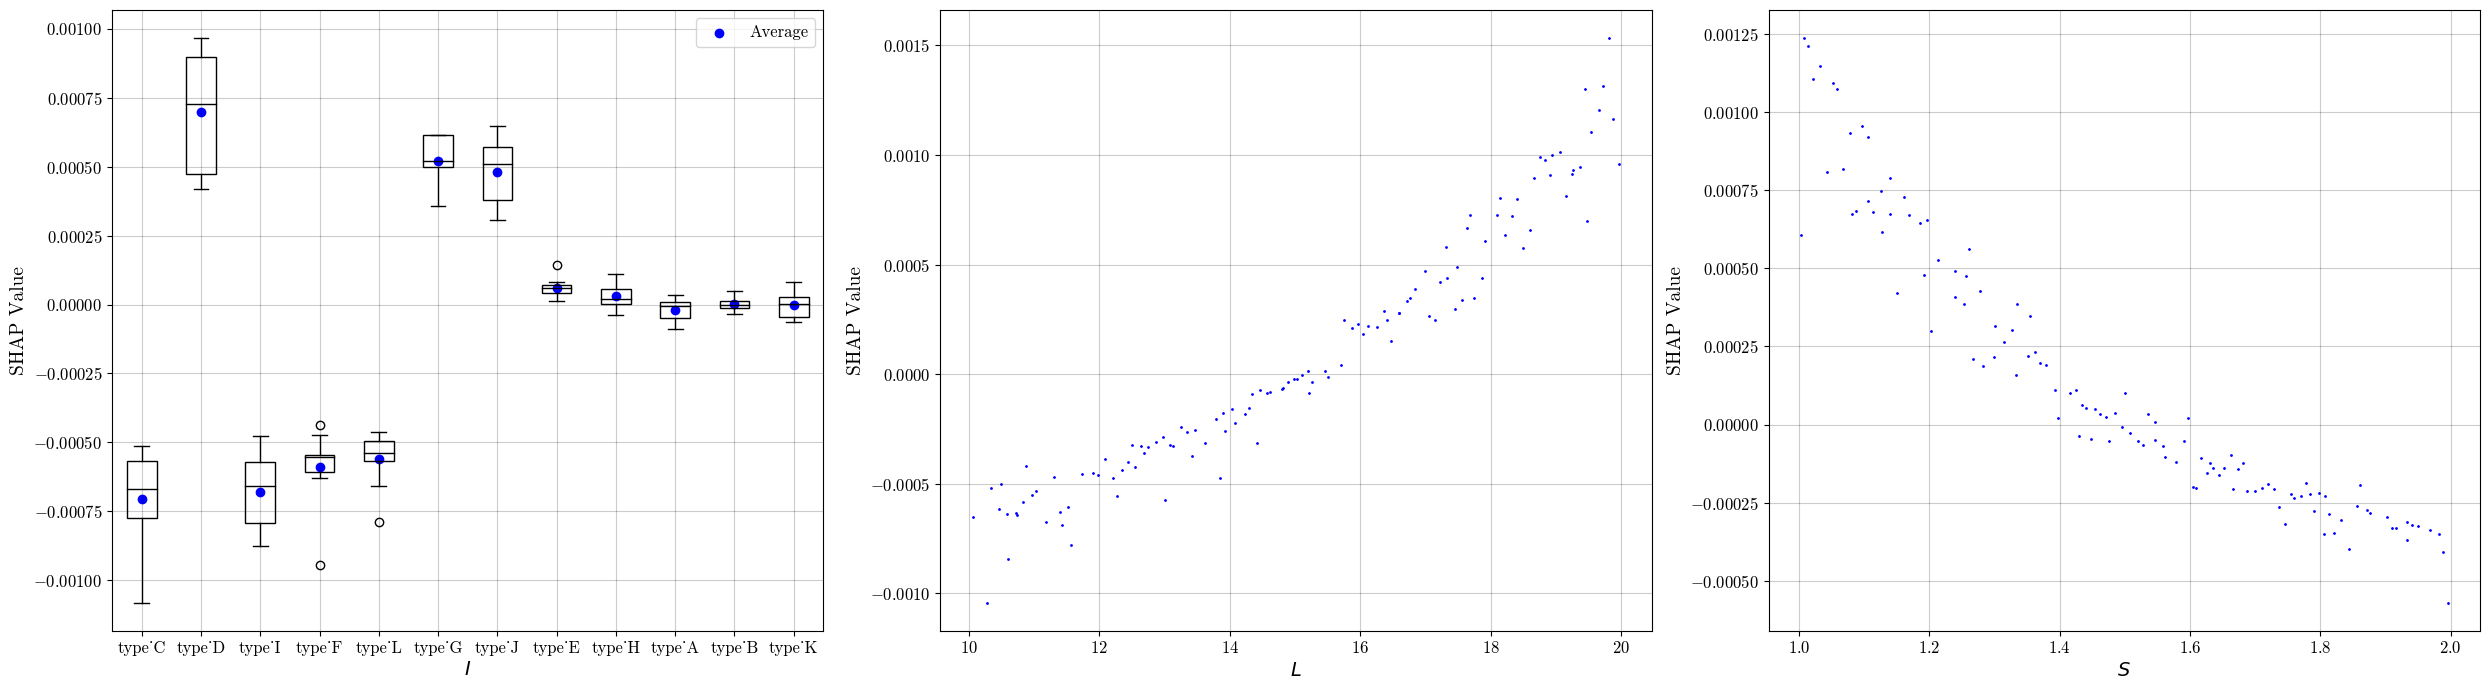

In [11]:
%%time
features = [0, 1, 2]

explainer_train.dependence_plot(
    features, 
    sort_based_on_importance=True,
    figsize=[25, 7],
)

CPU times: user 706 ms, sys: 18.6 ms, total: 725 ms
Wall time: 286 ms


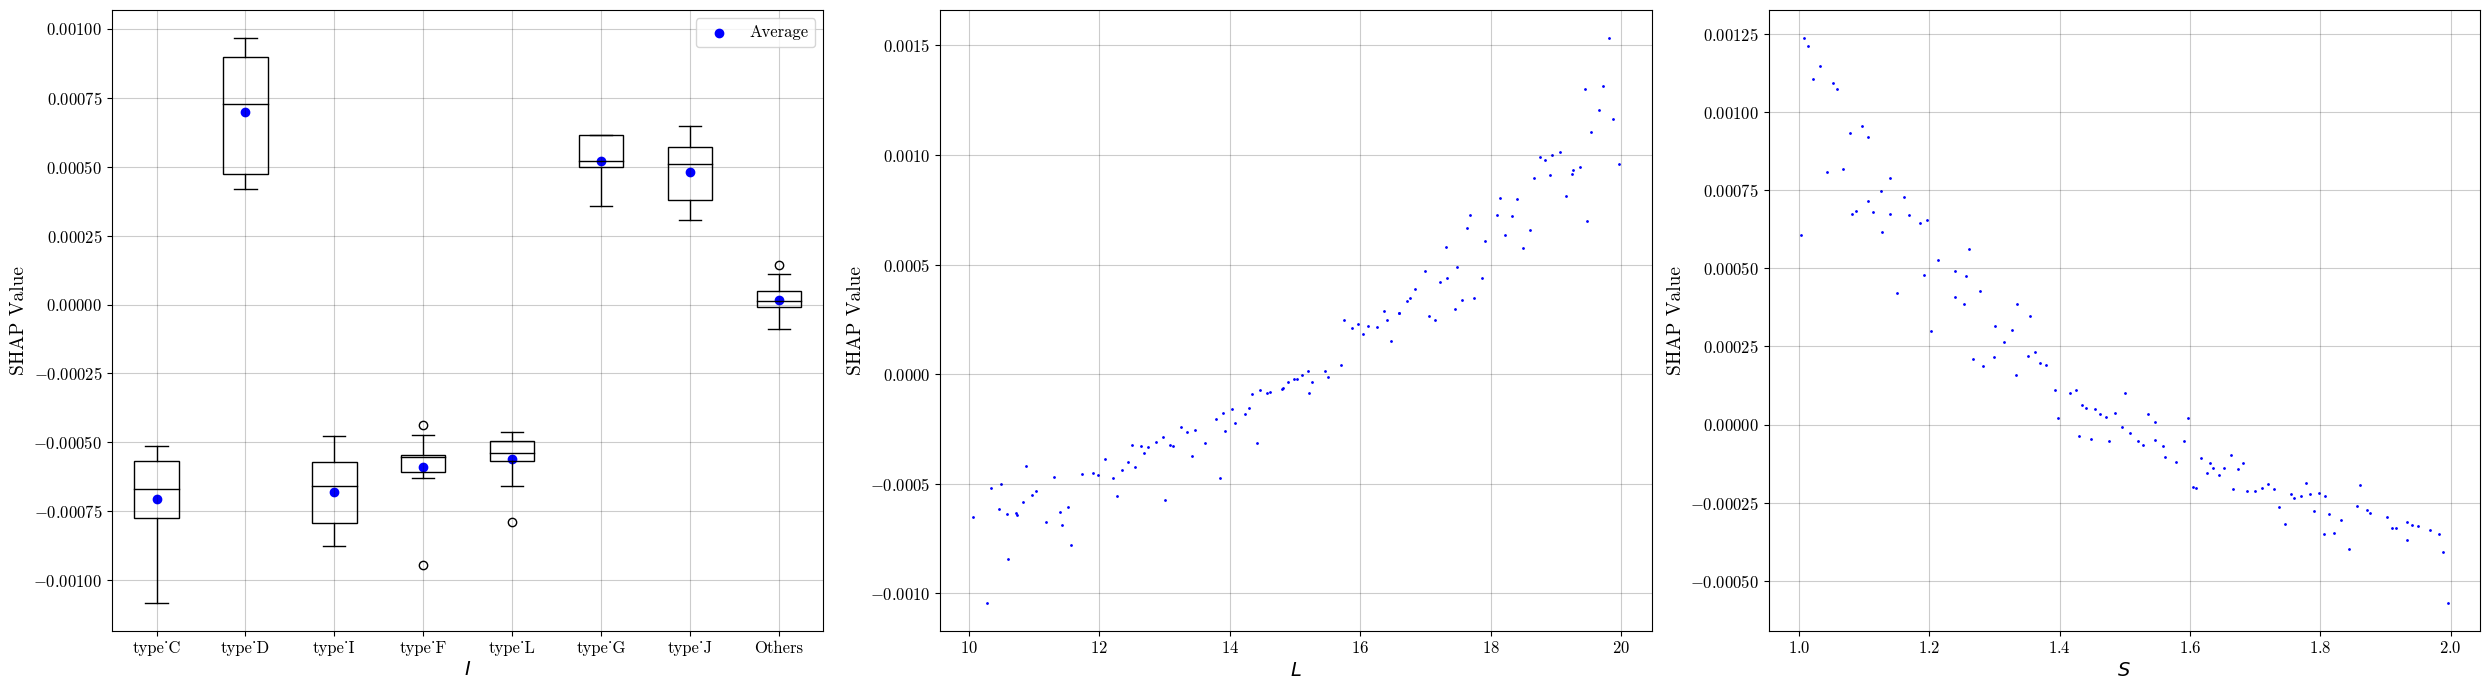

In [12]:
%%time
features = [0, 1, 2]

explainer_train.dependence_plot(
    features, 
    sort_based_on_importance=True,
    figsize=[25, 7],
    max_num_entities=7,
)

CPU times: user 664 ms, sys: 24.4 ms, total: 688 ms
Wall time: 264 ms


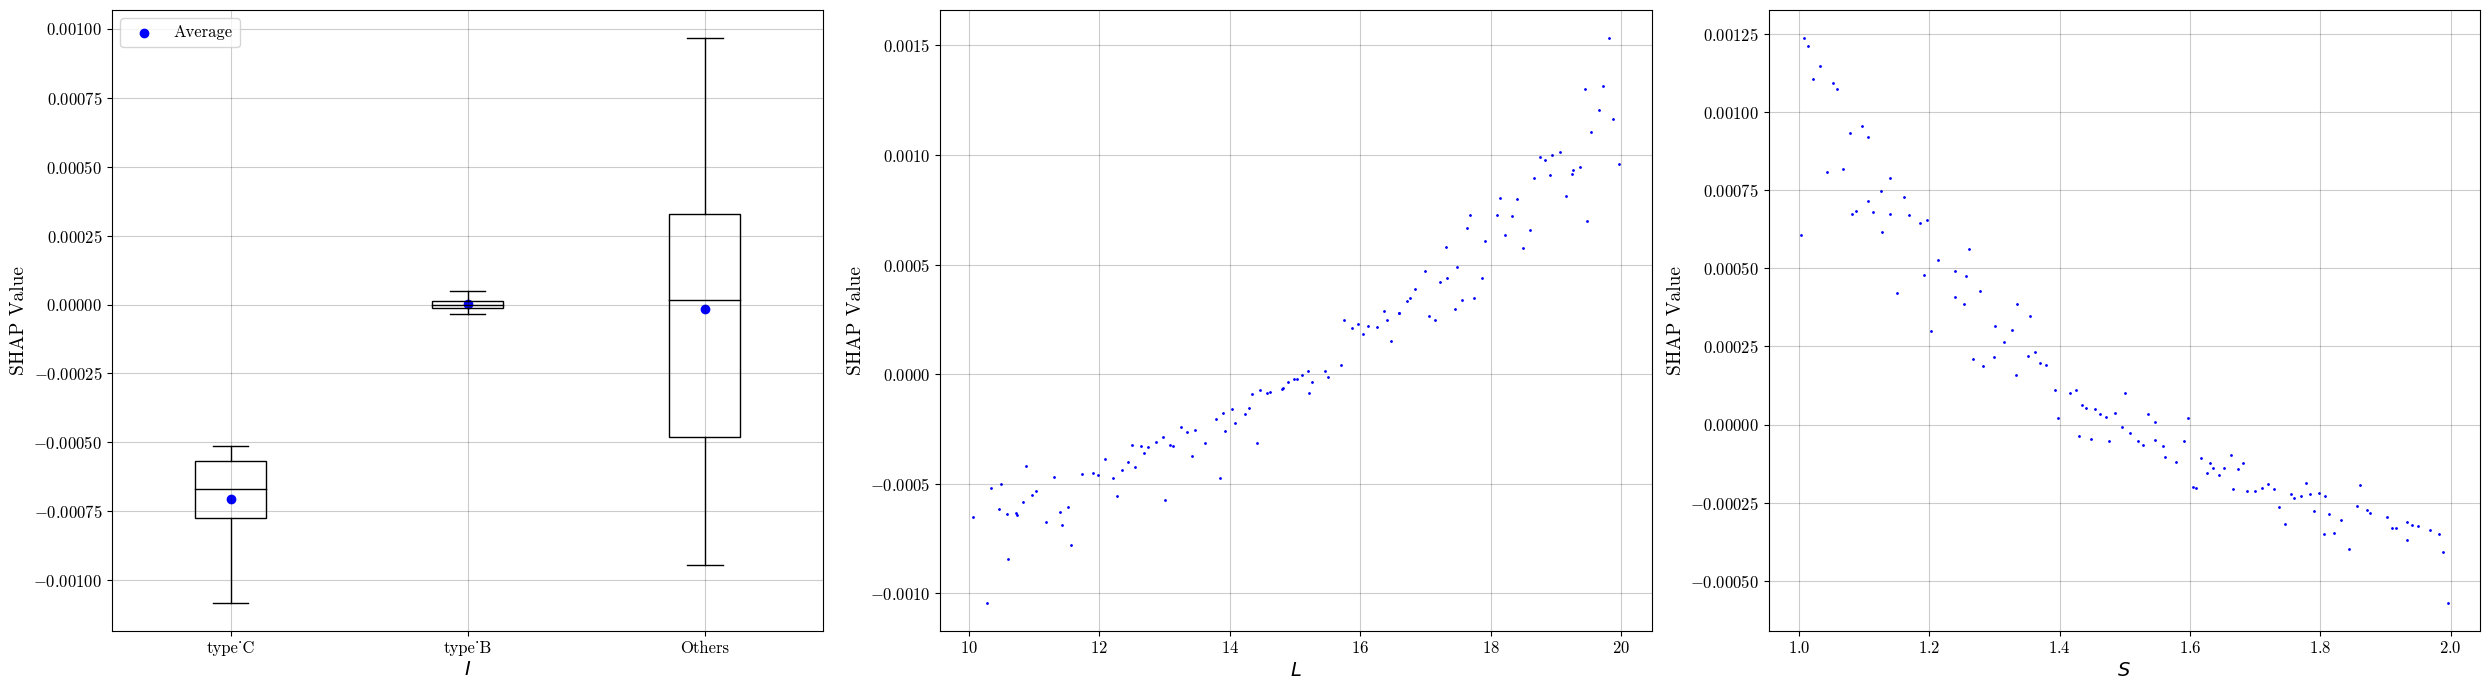

In [13]:
%%time
features = [0, 1, 2]

explainer_train.dependence_plot(
    features, 
    sort_based_on_importance=True,
    figsize=[25, 7],
    selected_entity_values={0:["type_B", "type_C"]},
)

## Interaction plot

CPU times: user 300 ms, sys: 29 ms, total: 329 ms
Wall time: 190 ms


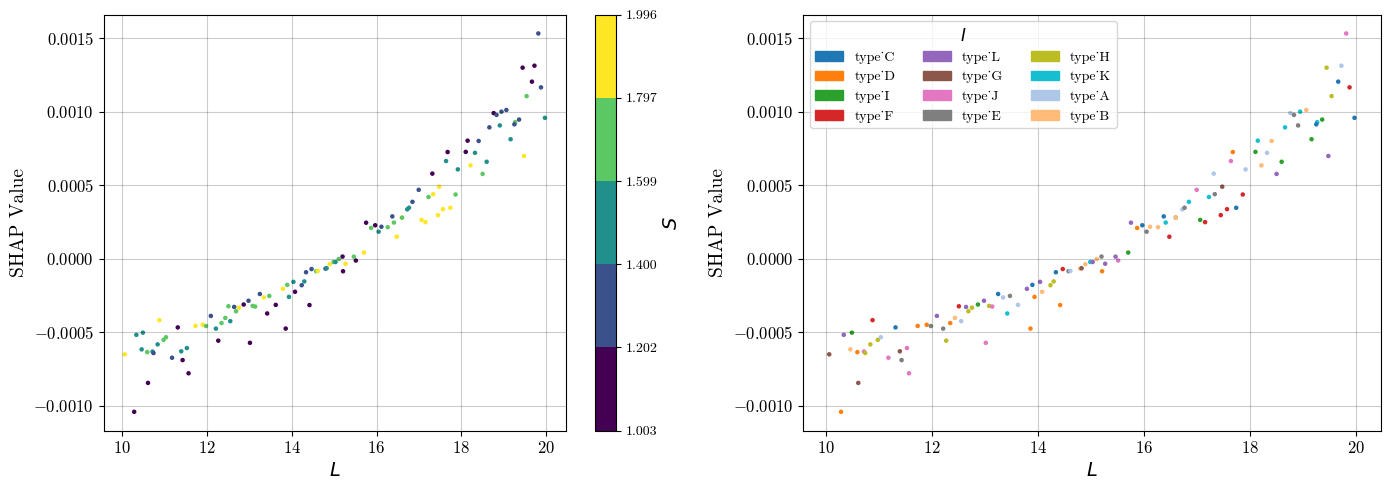

In [14]:
%%time
feature_pairs = [(1, 2), (1, 0)]
explainer_train.interaction_plot(
    feature_pairs, 
    n_color=5,
)

CPU times: user 255 ms, sys: 9.72 ms, total: 264 ms
Wall time: 121 ms


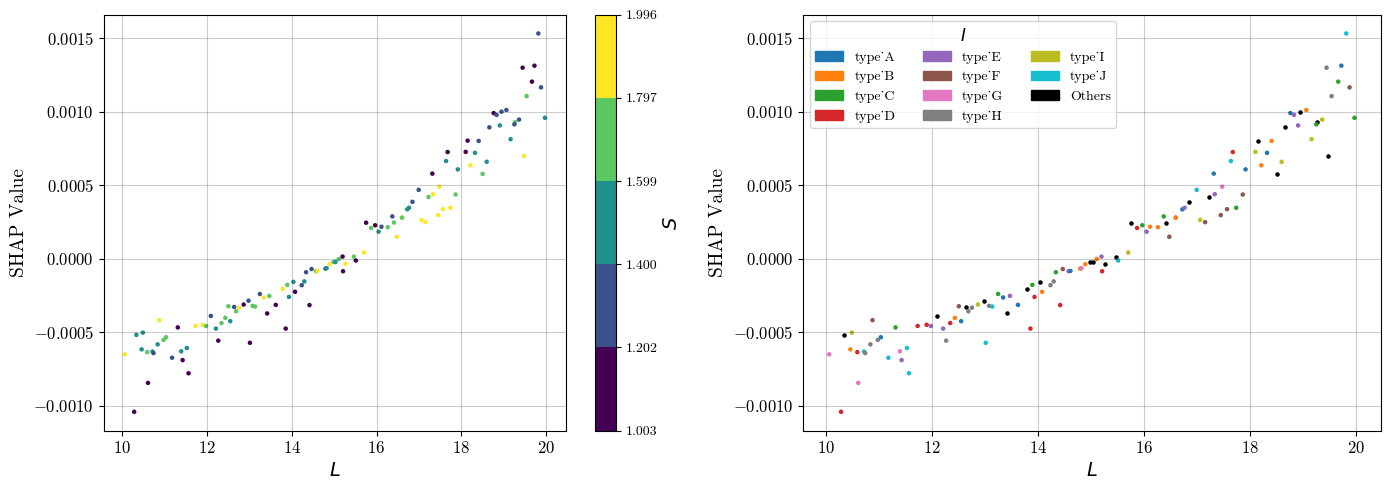

In [15]:
%%time
feature_pairs = [(1, 2), (1, 0)]
explainer_train.interaction_plot(
    feature_pairs, 
    n_color=5,
    max_num_entities=10,
    sort_based_on_importance={0: False},
)

CPU times: user 266 ms, sys: 15.5 ms, total: 281 ms
Wall time: 127 ms


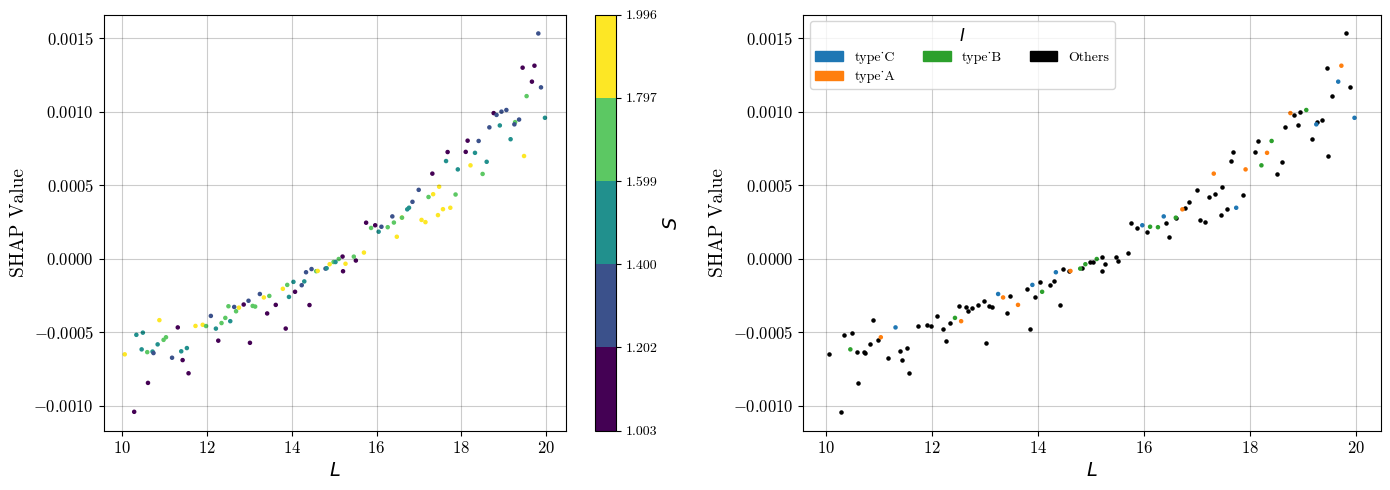

In [16]:
%%time
feature_pairs = [(1, 2), (1, 0)]
explainer_train.interaction_plot(
    feature_pairs, 
    n_color=5,
    selected_entities={0: [0, 1, 2]},
)

CPU times: user 233 ms, sys: 8.07 ms, total: 241 ms
Wall time: 110 ms


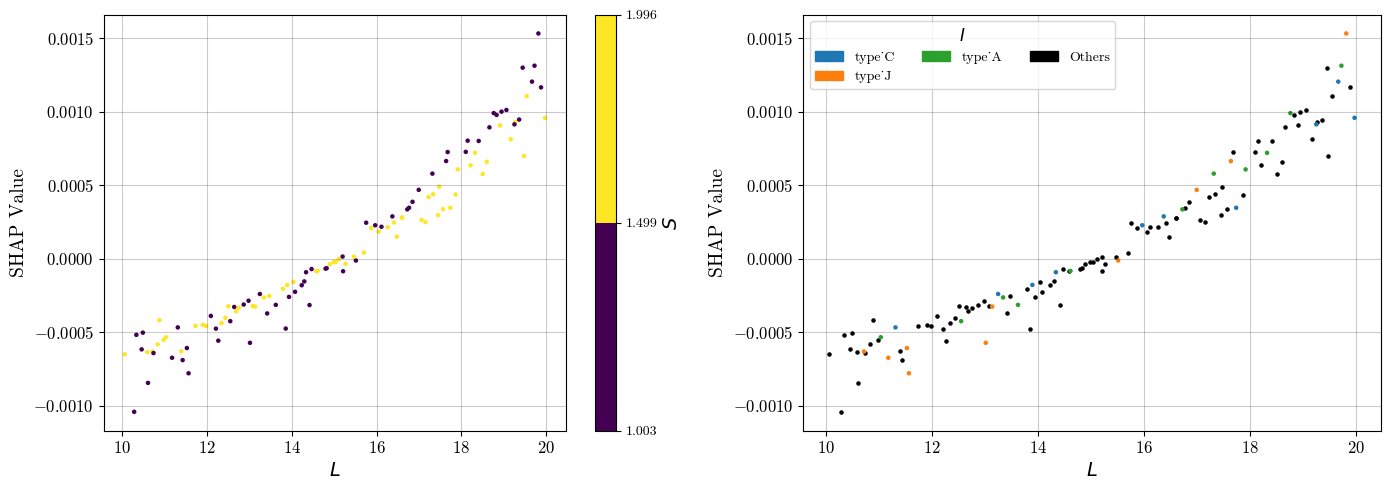

In [17]:
%%time
feature_pairs = [(1, 2), (1, 0)]
explainer_train.interaction_plot(
    feature_pairs, 
    n_color=2,
    selected_entity_values={0: ["type_A", "type_J", "type_C"]},
)

## Summary plot

CPU times: user 353 ms, sys: 13.8 ms, total: 366 ms
Wall time: 134 ms


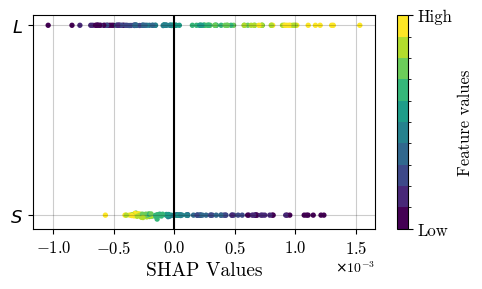

In [18]:
%%time
explainer_train.summary_plot(figsize=(5, 3), n_color=10)

CPU times: user 192 ms, sys: 14.4 ms, total: 206 ms
Wall time: 85 ms


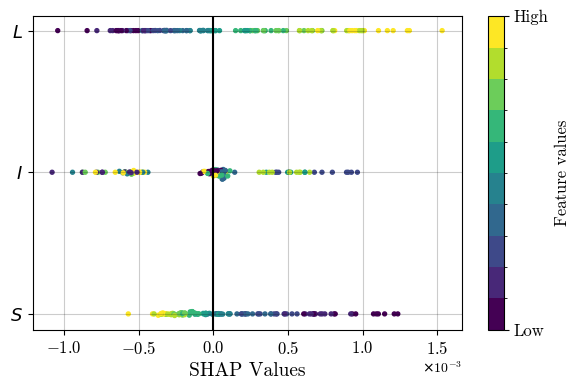

In [19]:
%%time
explainer_train.summary_plot(
    n_color=10, 
    include_cat=True
)

CPU times: user 168 ms, sys: 9.39 ms, total: 178 ms
Wall time: 71.5 ms


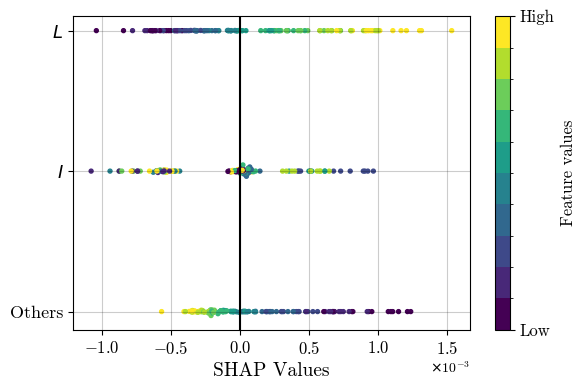

In [20]:
%%time
explainer_train.summary_plot(
    include_cat=True, 
    max_num_features=2
)